## Bounding box augmentation for object detection ##

In [1]:
import os
import sys
import glob
import logging
import json
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import cv2

import albumentations as alb

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import ImageData
from computervision.transformations import AugmentationTransform

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

Package version: v0.0.2
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
data_dir = os.path.join(os.environ.get('HOME'), 'data')
print(f'data_dir: {data_dir}')

# Directory to store the data
dataset_dir = os.path.join(data_dir, 'dentex')

# After extraction from the .tar.gz archive, the images should be on the local fs (see the first notebook)
xrays_dir = os.path.join(dataset_dir, 'cropped')

data_dir: /app/data


## Load the annotations ##

In [3]:
parquet_file_name = 'train_quadrant_enumeration_cropped.parquet'
parquet_file = os.path.join(xrays_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')
display(df.head())

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada
0,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",494,779,train_0_01.png,train_0,1,1,1,11,8
1,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",494,779,train_0_01.png,train_0,1,1,2,12,7
2,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",494,779,train_0_01.png,train_0,1,1,3,13,6
3,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",494,779,train_0_01.png,train_0,1,1,4,14,5
4,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",494,779,train_0_01.png,train_0,1,1,5,15,4


In [4]:
# Let's make sure that we have the expected number of images available
# If the image numbers don't match, please run the first three notebooks.

expected_images = len(df['file_name'].unique())
file_list = glob.glob(os.path.join(xrays_dir, '*.png'))
print(f'Found {len(file_list)} images in {xrays_dir}')
print(f'Expected number of images is {expected_images}.')

# We want to be sure that the number of images is correct before we continue
assert expected_images == len(file_list), \
    f'WARNING: expected images ({expected_images}) != images on file system ({len(file_list)})'

Found 5065 images in /app/data/dentex/cropped
Expected number of images is 5065.


### Bounding box format ###

In [5]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey'):
    offset_xy = (10, 100)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

### Augmenting bounding boxes ###

In [6]:
# Bounding box format definition
box_format = {'format': 'coco',
              'label_fields': ['quadrant', 'position']}
bbox_params = alb.BboxParams(**box_format)
display(bbox_params)

BboxParams(format=coco, label_fields=['quadrant', 'position'], min_area=0.0, min_visibility=0.0, min_width=0.0, min_height=0.0, check_each_transform=True, clip=False)

train_209
Image file for xray train_209 and quadrants 14: train_209_14.png
(725, 710, 3)


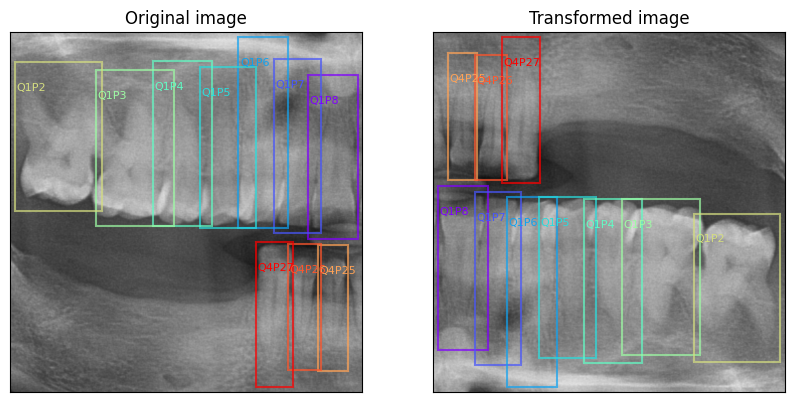

In [7]:
# Pick a panoramic image
idx = 123
file_base_name = sorted(list(df['file_base_name'].unique()))[idx]
print(file_base_name)

# Pick a quadrant
quadrants = 14
# The data frame with the bounding boxes
df_file = df.loc[(df['file_base_name'] == file_base_name) & (df['quadrants'] == quadrants)]
file_name = df_file['file_name'].tolist()[0]
print(f'Image file for xray {file_base_name} and quadrants {quadrants}: {file_name}')

# Load the image
file = os.path.join(xrays_dir, file_name)
im = ImageData().load_image(file)
# For the model, we need RGB images
im = ImageData().np2color(im)
print(im.shape)

# Prepare bounding boxes
# Each row is [x_min, x_max, bbox_width, bbox_height]
box_list = df_file['bbox'].tolist()
bboxes = np.array(box_list)

# Use two categories of annotations: quadrants and positions
quadrant_list = df_file['quadrant'].tolist()
position_list = df_file['ada'].tolist()
labels = {'quadrant': quadrant_list,
          'position': position_list}
label_list = [f'Q{q}P{p}' for q, p in zip(quadrant_list, position_list)]

# Just do some flips for demonstration
transformation_list = [alb.HorizontalFlip(p=1.0), alb.VerticalFlip(p=1)]

alb_transform = alb.Compose(transformation_list, bbox_params=bbox_params)

# Carry out the transformation
transformed = alb_transform(image=im, bboxes=bboxes, **labels)

# Retrieve the image and annotations of the transformed image
transformed_image = transformed['image']
transformed_box_list = list(transformed['bboxes'])
transformed_quadrant_list = list(np.array(transformed['quadrant']).astype(int))
transformed_position_list = list(np.array(transformed['position']).astype(int))
transformed_label_list = [f'Q{q}P{p}' for q, p in zip(transformed_quadrant_list, 
                                                      transformed_position_list)]

# Lets plot the image with the bounding boxes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0] = plot_boxes(image=im, box_list=box_list, label_list=label_list, ax=ax[0])
ax[1] = plot_boxes(image=transformed_image, box_list=transformed_box_list, label_list=transformed_label_list, ax=ax[1])
ax[0].set(title='Original image')
ax[1].set(title='Transformed image')
plt.show()

### The DETRansform Class ###

In [8]:
class DETRansform:
    
    def __init__(self, transformations: list = None, bbox_format: dict = None):
        self.transformations = transformations
        self.bbox_format = bbox_format
        if transformations is None:
            self.transformations = [alb.NoOp()]
        if bbox_format is None:
            self.bbox_format = {'format': 'coco', 
                                'label_fields': ['quadrants', 'positions'],
                                'clip': True,
                                'min_area': 1000}

    def transform(self, image, bboxes: list, label_fields: list):
        
        # The label_fields should be one list for each field
        try:
            assert len(label_fields) == len(self.bbox_format.get('label_fields'))
            labels = dict(zip(self.bbox_format.get('label_fields'), label_fields))
        except Exception as e:
            print(f'The argument "label_fields" must be a list of lists with labels: {self.bbox_format.get("label_fields")}')
        
        # The bboxes variable must be a list: convert to (N x 4) numpy array
        assert isinstance(bboxes, list)
        bbox_array = np.array(bboxes).reshape(len(bboxes), 4)
        
        # Set up the transformation
        transformation = alb.Compose(self.transformations, bbox_params=alb.BboxParams(**self.bbox_format))
        transformed = transformation(image=image, bboxes=bbox_array, **labels)
        
        # Create the output
        output = {'image': transformed['image'], 'bboxes': list(transformed['bboxes'].astype(int))}
        output.update({field: transformed[field] for field in self.bbox_format.get('label_fields')})
        
        return output

    def format_transform(self, image, image_id, bboxes: list, labels: list):
        """ This method produces the formatted input for the RT-DETR model. """
        
        # Consistency checks
        assert len(bboxes) == len(labels), 'We need as many labels as bounding boxes: len(bboxes) == len(labels)!'
        assert len(self.bbox_format.get('label_fields')) == 1, 'We can only use one set of labels.'
        assert self.bbox_format.get('format') == 'coco', f'Bounding box format must be "coco", but is: {bbox_format.get("format")}!'
        assert isinstance(image_id, int), 'Image ID must be of type int.'
        assert all(isinstance(l, int) for l in labels), 'All labels must be class IDs (int).'
        
        # Transform the image
        output = self.transform(image=image, bboxes=bboxes, label_fields=[labels])
        output_image = output['image']
        output_bboxes = output['bboxes']
        output_labels = output.get(self.bbox_format.get('label_fields')[0])

        # Annotations for the model using the transformed image, bounding boxes and labels
        annotation_list = []
        # This list can only contain data if the transformed output contains at leaset one bounding box
        if len(output_labels) > 0:
            for bbox, label in zip(output_bboxes, output_labels):
                assert len(bbox) == 4, f'Incompatible bounding box: {bbox}'
                annotation = {'image_id': image_id,
                              'category_id': int(label),
                              'bbox': list(bbox),
                              'iscrowd': 0,
                              'area': bbox[2] * bbox[3]}
                annotation_list.append(annotation)
        output_annotations = {'image_id': image_id, 'annotations': annotation_list}
        return output_image, output_annotations

In [9]:
# Try the class to carry out the image transformations
boxes = df_file['bbox'].tolist()
quadrants = df_file['quadrant'].tolist()
positions = df_file['ada'].tolist()

transformations = [alb.HorizontalFlip(p=1.0), alb.VerticalFlip(p=1)]

# Get the output from this transformation
detr = DETRansform(transformations=transformations)
output = detr.\
    transform(image=im, bboxes=boxes, label_fields=[quadrants, positions])

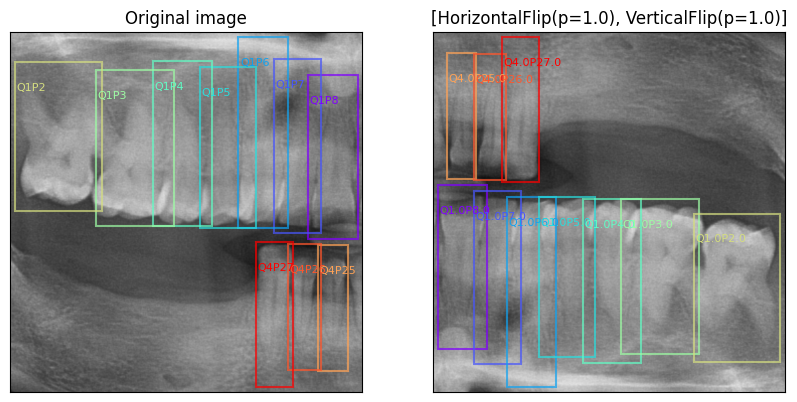

In [10]:
# Plot the results
# Format the labels
labels = [f'Q{q}P{p}' for q, p in zip(quadrants, positions)]
transformed_labels = [f'Q{q}P{p}' for q, p in zip(output['quadrants'], output['positions'])]

# Plot the output
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0] = plot_boxes(image=im, box_list=boxes, label_list=labels, ax=ax[0])
ax[1] = plot_boxes(image=output['image'], box_list=output['bboxes'], label_list=transformed_labels, ax=ax[1])
ax[0].set(title='Original image')
ax[1].set(title=transformations)
plt.show()

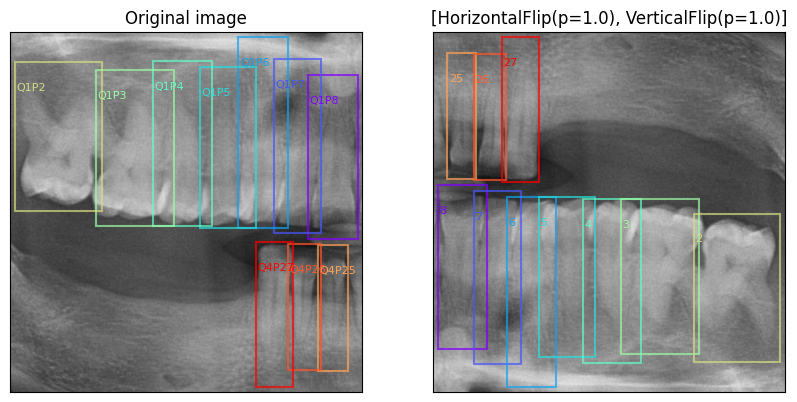

In [11]:
# Test the DETR formatting of the annotations
# The model can only take one set of annotations, so let's change the label fields

transformations = [alb.HorizontalFlip(p=1.0), alb.VerticalFlip(p=1)]
bbox_format = {'format': 'coco', 
               'label_fields': ['tooth_positions'],
               'clip': True,
               'min_area': 1000}

detr = DETRansform(transformations=transformations, bbox_format=bbox_format)
output_image, output_annotations = detr.format_transform(image=im, image_id=123, bboxes=boxes, labels=positions)
annotations = output_annotations.get('annotations')
output_box_list = [annotation['bbox'] for annotation in annotations]
output_label_list = [annotation['category_id'] for annotation in annotations]

# Plot the output
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0] = plot_boxes(image=im, box_list=boxes, label_list=labels, ax=ax[0])
ax[1] = plot_boxes(image=transformed_image, box_list=output_box_list, label_list=output_label_list, ax=ax[1])
ax[0].set(title='Original image')
ax[1].set(title=transformations)
plt.show()

### Bounding Box Augmentation for Object Detection ###

In [12]:
# Pick a panoramic x-ray image
idx = 10
quadrants = 23
base_name_list = sorted(list(df['file_base_name'].unique()))
file_base_name = base_name_list[idx]
df_file = df.loc[(df['file_base_name'] == file_base_name) & (df['quadrants'] == quadrants)]
display(df_file)

# Load the image
file_name = df_file['file_name'].to_list()[0]
file = os.path.join(xrays_dir, file_name)
im = ImageData().load_image(file)
# For the model, we need RGB images
im = ImageData().np2color(im)
print(im.shape)

box_list = df_file['bbox'].tolist()
position_list = df_file['ada'].tolist()
quadrant_list = df_file['quadrant'].tolist()
label_list = [f'Q{quadrant}P{position}' for quadrant, position in zip(quadrant_list, position_list)]

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada
965,"[10, 118, 69, 331]","[[32, 157, 21, 188, 10, 266, 10, 305, 15, 349,...",701,806,train_107_23.png,train_107,23,2,1,21,9
966,"[74, 121, 66, 295]","[[99, 135, 82, 168, 82, 196, 76, 235, 74, 277,...",701,806,train_107_23.png,train_107,23,2,2,22,10
967,"[140, 88, 61, 305]","[[143, 138, 143, 155, 143, 216, 143, 268, 140,...",701,806,train_107_23.png,train_107,23,2,3,23,11
968,"[182, 105, 81, 283]","[[210, 105, 201, 124, 182, 202, 182, 243, 182,...",701,806,train_107_23.png,train_107,23,2,4,24,12
969,"[243, 74, 75, 289]","[[246, 107, 246, 138, 246, 199, 243, 243, 246,...",701,806,train_107_23.png,train_107,23,2,5,25,13
970,"[296, 46, 119, 289]","[[313, 88, 313, 127, 299, 213, 296, 274, 307, ...",701,806,train_107_23.png,train_107,23,2,6,26,14
971,"[382, 24, 136, 267]","[[382, 74, 390, 99, 393, 163, 396, 207, 418, 2...",701,806,train_107_23.png,train_107,23,2,7,27,15
972,"[499, 10, 125, 242]","[[501, 63, 499, 102, 501, 168, 518, 213, 543, ...",701,806,train_107_23.png,train_107,23,2,8,28,16
973,"[40, 474, 100, 217]","[[118, 691, 110, 655, 96, 602, 76, 549, 63, 51...",701,806,train_107_23.png,train_107,23,3,1,31,24
974,"[99, 463, 97, 225]","[[196, 688, 165, 641, 157, 616, 146, 596, 126,...",701,806,train_107_23.png,train_107,23,3,2,32,23


(701, 806, 3)


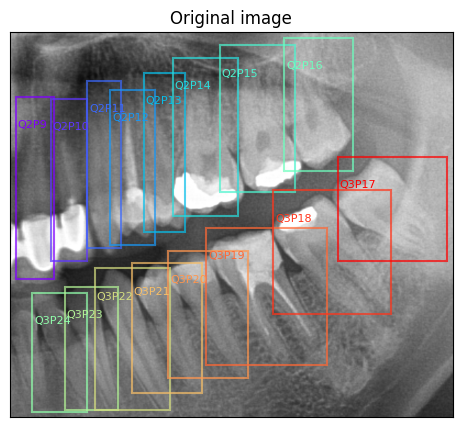

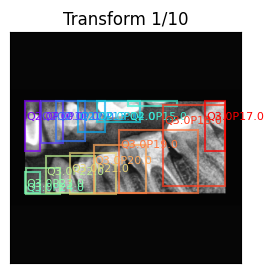

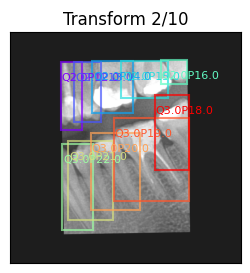

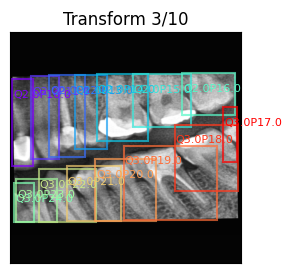

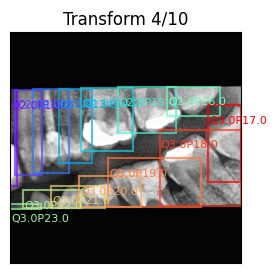

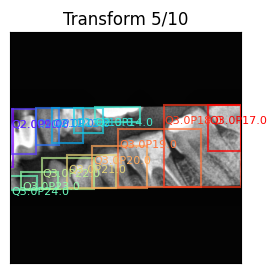

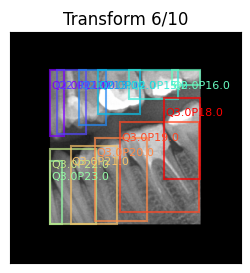

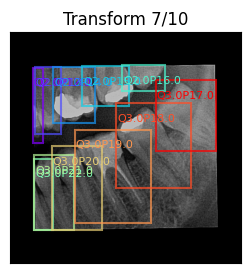

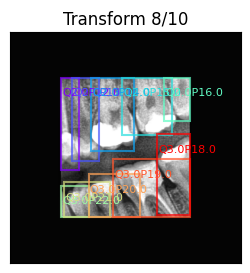

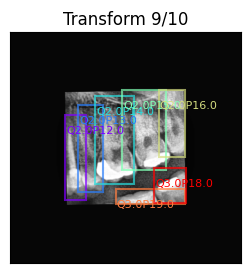

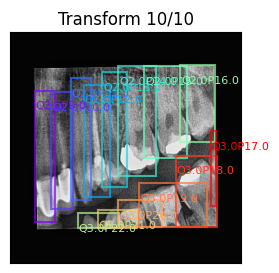

In [13]:
# Crop to the output format
im_size = 640

# We can get this transformation from the dataclass
transformation_list = AugmentationTransform(im_width=im_size, im_height=im_size).\
    get_transforms('train_14_23')

# Plot the original image with bounding boxes
fig, ax = plt.subplots(figsize=(7, 5))
ax = plot_boxes(image=im, box_list=box_list, label_list=label_list, ax=ax)
ax.set(title='Original image')
plt.show()

# Plot the augmentations
# Run the augmentations multiple times
runs = 10
for r in range(runs):
    # Run the transformation
    output = DETRansform(transformations=transformation_list).\
        transform(image=im, bboxes=box_list, label_fields=[quadrant_list, position_list])
    transformed_labels = [f'Q{q}P{p}' for q, p in zip(output['quadrants'], output['positions'])]
    transformed_boxes = output['bboxes']
    transformed_boxes_area_list = [box[2]*box[3] for box in transformed_boxes]
    # print(transformed_boxes_area_list)
    # Plot the output
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = plot_boxes(image=output['image'], box_list=transformed_boxes, label_list=transformed_labels, ax=ax)
    ax.set(title=f'Transform {r+1}/{runs}')
    plt.show()